# 第十一次作業

In [128]:
# 18.5, 18.7, 18.19, 18.23, 18.36, 18.38, 18.49

In [129]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 80
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
from statsmodels.stats.stattools import durbin_watson
from scipy.optimize import curve_fit

In [130]:
def CI_PI_regression(xdata, yval, x1, a):
    print("make CI and PI prediction at mean of x = ", x1)
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5 
    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    print("confidence interval of mean = [%0.4f, %0.4f] " % (lower_bound, upper_bound))
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
    CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
    return CI_PI
def forward_selection(input_df, depv="y", indepv = ["x1"]):
    selected = []
    candidates = indepv.copy()
    best_adjr2 = -1
    best_subset = []
    while len(candidates) > 0:
        print("Current Candidates: ", candidates)
        tmp_indep_subset = []
        tmp_model_adjr = []
        tmp_model_nindep = []
        for acandidate in candidates:
            tmplist = selected.copy()
            tmplist.append(acandidate)
            modelstr = depv + " ~ " + "+".join(tmplist)
            result6tmp = smf.ols(modelstr, data=input_df).fit()
            tmp_indep_subset.append(tmplist)
            tmp_model_adjr.append(result6tmp.rsquared_adj)
            tmp_model_nindep.append(len(tmplist))
        tmp_adjr2 = np.array(tmp_model_adjr)
        tmpind = tmp_adjr2.argmax()
        this_adjr2 = tmp_adjr2[tmpind]
        selected = tmp_indep_subset[tmpind]
        if this_adjr2 <= 0:
            raise("Encounterd negative Adj R2. Stop.")
        print("===============")
        print("Current best model: ", selected)
        print("Current best AdjR2: ", this_adjr2)
        if this_adjr2 > best_adjr2:
            #print(" best result updated")
            best_adjr2 = this_adjr2
            best_subset = selected
        candidates = set(candidates) - set(selected)
        candidates = list(candidates)
    print("best_adjr2 = ", best_adjr2)
    print("best_subset = ", best_subset)
    modelstr = depv + " ~ " + "+".join(best_subset)
    result6b = smf.ols(modelstr, data=input_df).fit()
    print(result6b.summary()) 
    return result6b
def Estimated_model(xname,result,xsize,yname):
    b = []
    print('Estimated model:')
    print(yname,'=')
    for i in range(xsize+1):
        b.append(result.params[i])
        if result.params[i] >= 0:
            print('+ %.2f'%b[i],xname[i])
        else:
            print('- %.2f'%-b[i],xname[i])
def objective(x, a, b, c):
    return a*x + b * x**2 + c
def Chi_Square_for_Normality(stand_res, N, a): 
    m = np.mean(stand_res)
    s = np.std(stand_res)    
    prob_bins = np.zeros((N + 1))
    z_bins = np.zeros((N + 1))
    z_bins[0] = -4
    z_bins[N] = 4
    for i in range(0, N+1):
        prob_bins[i] = i/N
    for j in range(1, N):
        z_bins[j] = m + stats.norm.isf(1 - prob_bins[j]) * s
    counts, bins = np.histogram(stand_res, bins=z_bins)
    nobs = counts.sum()
    prob_e = np.zeros((N))
    for i in range(1, N+1):
        prob_e[i - 1] = prob_bins[i] - prob_bins[i - 1]
    freq_e = nobs * prob_e
    freq_o = counts
    if np.sum(freq_e < 5) > 0:
        print("Rule of five is not met. ")
    else:
        chi_stat, pval = stats.chisquare(freq_o, freq_e)
        chi_pval = stats.chi2.sf(chi_stat, N - 3)
        print("Chi-squared test: statistics = %0.4f, p-value = %0.4f" % (chi_stat, chi_pval))
    df = freq_o.shape[0]-3
    crit_value = stats.chi2.ppf(1 - a, df)
    print("Critical value = %0.4f (defree of freedom = %d)" % (crit_value, df))
    if crit_value > 0.05:
        print('\nSince p-value > 0.05, we do not reject H0 and we may conclude errors are normally distributed.')
    else:
        print('\nSince p-value < 0.05, we reject H0 and conclude errors are not normally distributed.')
    return chi_pval

<div style="background-color:#D9D9D9;"><font size="5"> 18.5</font></div>

Xr18-05 A person starting a new job always takes a certain amount of time to 
adjust fully. In repetitive-task situations, such as on an assembly line, significant 
productivity gains can occur within a few days. In an experiment to study this 
phenomenon, the average amount of time required for a new employee to install 
electronic components in a computer was measured for her first 10 days. These 
data are shown here.<br>
A first-order model and a second-order model were proposed.<br>
a. Write the equation for each model.<br>
b. Analyze both models. Determine whether they are valid.<br>
c. Which model fits better? Explain<br>

In [131]:
#(a.)
df1 = pd.read_excel('Xr18-05.xlsx')
display(df1.head())

,Time,Day
0,40,1
1,41,2
2,36,3
3,38,4
4,33,5


### first-order model

first order


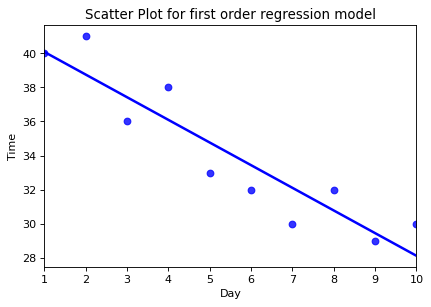

y = 41.4000 + -1.3273 x


In [132]:
y_var = df1['Time'].values
xnames =['Day']
print("first order")
for aname in xnames:
    x_var = df1[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df1, color = 'b', ci = None)
    plt.title('Scatter Plot for first order regression model')
    plt.xlabel(aname)
    plt.ylabel('Time')
    plt.show()
df1_result = smf.ols('Time~ Day', data=df1).fit()
b1 = df1_result.params[1]
b0 = df1_result.params[0]
print("y = %0.4f + %0.4f x" % (b0, b1))

In [133]:
y_data = df1['Time']
X_data_ar = np.array([df1['Day']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = ['Day'])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
result_reg = olsmod.fit()
print(result_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     45.48
Date:                Wed, 11 May 2022   Prob (F-statistic):           0.000146
Time:                        12:21:19   Log-Likelihood:                -18.882
No. Observations:                  10   AIC:                             41.76
Df Residuals:                       8   BIC:                             42.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4000      1.221     33.902      0.0

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


second order : 
[-2.49393939  0.10606061 43.73333333]
y = -2.49394 * x + 0.10606 * x^2 + 43.73333


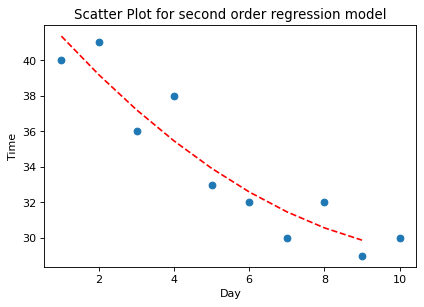

In [134]:
y_var = df1['Time'].values
xnames = ['Day']
print("second order : ")
for aname in xnames:
    x_var = df1[aname].values
    popt, _ = curve_fit(objective, x_var, y_var)
    print(popt)
    a, b, c = popt
    print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
    plt.scatter(x_var, y_var)
    x_line = np.arange(min(x_var), max(x_var), 1)
    y_line = objective(x_line, a, b, c)
    plt.plot(x_line, y_line, '--', color='red')
    plt.xlabel(aname)
    plt.ylabel('Time')
    plt.title('Scatter Plot for second order regression model')
    plt.show()

,Time,day_std,day_std2
0,40,1,1
1,41,2,4
2,36,3,9
3,38,4,16
4,33,5,25


                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     26.98
Date:                Wed, 11 May 2022   Prob (F-statistic):           0.000513
Time:                        12:21:20   Log-Likelihood:                -17.560
No. Observations:                  10   AIC:                             41.12
Df Residuals:                       7   BIC:                             42.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.7333      1.969     22.208      0.0

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


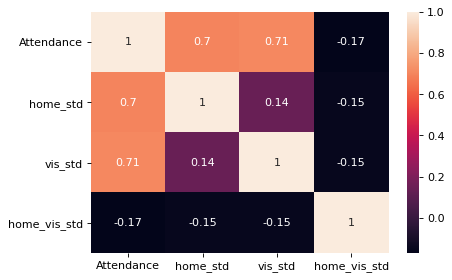

In [135]:
#(b.)
dep_var = df1['Time']
indep_var = df1[['Day']]
#Change the names so that we will not get confused
indep_var.columns = ['day_std']
indep_mean = indep_var.mean()
indep_var['day_std2'] = indep_var['day_std'] ** 2
df1_1 = indep_var.copy()
df1_1.insert(0, 'Time', dep_var)
display(df1_1.head())
corr2c = df1b.corr()
_ = sns.heatmap(corr2c, annot=True)

y_data_b = df1_1['Time']
X_data_ar_b = np.array([df1_1['day_std'], df1_1['day_std2']])
X_data_b_T = X_data_ar_b.T
X_data_b = pd.DataFrame(X_data_b_T, columns = ['day_std', 'day_std2'])
X_data_b = sm.add_constant(X_data_b)
olsmod_b = sm.OLS(y_data_b, X_data_b)
result_reg_b = olsmod_b.fit()
print(result_reg_b.summary())

The F statistics appear to be significant. and the t statistics is also able to reject H0 of some independent varibles. The model is valid.
From the slope and the diagram, the  𝛽 coefficients can be interpreted as slopes.
r - r^2 < 0.06, the model fits well. <br>We can't infer that there are multicollinearity in the model.

### (a.)
First-order: 41.4 - 1.3273 Day <br>
Second-order:  33.2250 - 1.3273 Day + 0.1061 Day^2

### (b.)
first-order: <br>
H0: beta_1 = 0<br>
H1: At least one of the betas != 0<br>

second-order: <br>
H0: beta_1 = beta_2 = 0<br>
H1: At least one of the betas != 0<br>

From the OLS table<br>
both of the p-value for F-test < 0.05, we can reject both H0.<br>
There is enough evidence to conclude that the model is valid.

### (c.)
The second-order model fits better because of its Adj. R-squared > the first-order's.<br>
it can explain more about the data

<div style="background-color:#D9D9D9;"><font size="5"> 18.7</font></div>
Xr18-07 The manager of the food concession at a 
major league baseball stadium wanted to be able to 
predict the attendance of a game 24 hours in advance 
to prepare the correct amount of food for sale. He 
believed that the two most important factors were 
the home team’s winning percentage and the visiting 
team’s winning percentage. In order to examine his beliefs, he collected the attendance figures, the 
home team’s winning percentage, and the visiting 
team’s winning percentage for 40 randomly selected 
games from all the teams in the league.<br>
a. Conduct a regression analysis using a first-order 
model with interaction.<br>
b. Do these results indicate that your model is 
valid? Explain

In [136]:
df1 = pd.read_excel('Xr18-07.xlsx')
df1

,Attendance,Home %,Visiting %
0,14067,0.491,0.422
1,52488,0.563,0.574
2,12693,0.445,0.400
3,35954,0.544,0.539
4,36452,0.479,0.501
5,42620,0.500,0.557
6,34395,0.471,0.540
7,40859,0.577,0.508
8,42313,0.516,0.571
9,44490,0.500,0.543


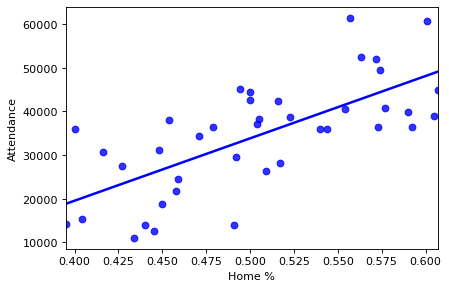

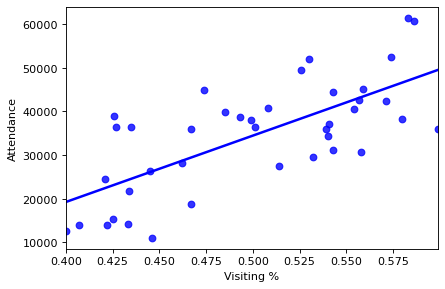

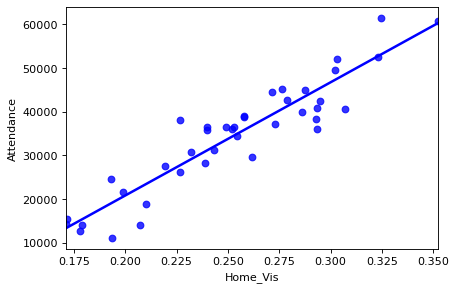

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     80.65
Date:                Wed, 11 May 2022   Prob (F-statistic):           4.82e-16
Time:                        12:21:22   Log-Likelihood:                -393.24
No. Observations:                  40   AIC:                             794.5
Df Residuals:                      36   BIC:                             801.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.204e+04   4.85e+04     -1.691      0.1

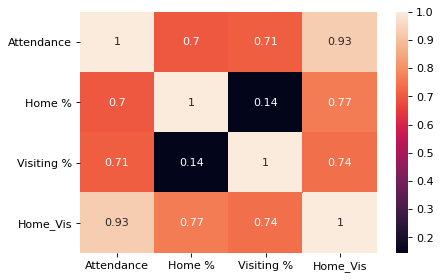

In [137]:
y_var = df1['Attendance'].values
df1["Home_Vis"] = df1['Home %']*df1['Visiting %']
xnames = ['Home %','Visiting %','Home_Vis']
for aname in xnames:
    x_var = df1[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df2, color = 'b', ci = None)
    plt.xlabel(aname)
    plt.ylabel('Attendance')
    plt.show()
corr = df2.corr()
_ = sns.heatmap(corr, annot=True)
y_data = df1['Attendance']
X_data_ar = np.array([df1['Home %'],df1['Visiting %'],df1["Home_Vis"]])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = ['Home %','Visiting %','Home_Vis'])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
result_reg = olsmod.fit()
print(result_reg.summary())
st, data, ss2 = sso.summary_table(result_reg, alpha=0.05)
print("Columns in data are: %s" % ss2)
#Predicted value
y_pre = data[:, 2]
#Studentized Residual
SD = data[:, 10]
mu = np.mean(SD)
sigma = np.std(SD)
print(SD)
print('mu = ', mu)
print('sigma = ', sigma)

xname = ["",'Home %','Visiting %','Home_Vis']
yname = 'Attendance'
xsize = 3
Estimated_model(xname,result_reg,xsize,yname)

The p-value of the F-test is smaller than 0.05, but no t can reject, there is multicollinearity.<br>
do data transformation

,Attendance,home_std,vis_std,home_vis_std
0,14067,-0.0135,-0.07815,0.001055
1,52488,0.0585,0.07385,0.004320
2,12693,-0.0595,-0.10015,0.005959
3,35954,0.0395,0.03885,0.001535
4,36452,-0.0255,0.00085,-0.000022


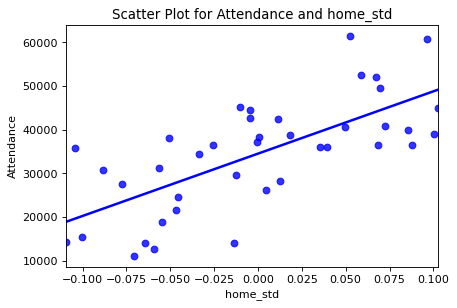

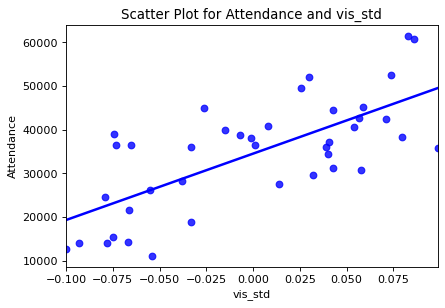

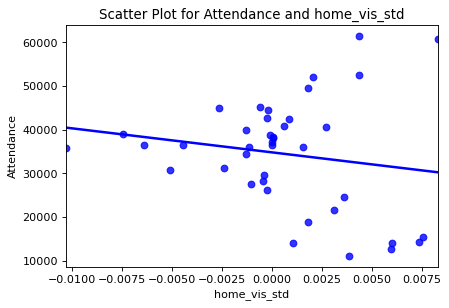

In [138]:
# 做Data Transformation
dep_var = df1['Attendance']
indep_var = df1[['Home %', 'Visiting %']]
#Change the names so that we will not get confused
indep_var.columns = ['home_std', 'vis_std']
indep_mean = indep_var.mean()
indep_var = indep_var - indep_mean
#indep_var['day_std2'] = indep_var['day_std'] ** 2
#indep_var['age_std2'] = indep_var['age_std'] ** 2
indep_var['home_vis_std'] = indep_var['home_std'] * indep_var['vis_std']
df1b = indep_var.copy()
df1b.insert(0, 'Attendance', dep_var)
display(df1b.head())
y_var = df1b['Attendance'].values
xnames = df1b.columns[1:]
for aname in xnames:
    x_var = df1b[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df1b, color = 'b', ci = None)
    #_ = plt.plot(x, y, 'o', color = 'b')
    plt.xlabel(aname)
    plt.ylabel('Attendance')
    plt.title('Scatter Plot for Attendance and ' +aname)
    plt.show()

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     80.65
Date:                Wed, 11 May 2022   Prob (F-statistic):           4.82e-16
Time:                        12:21:23   Log-Likelihood:                -393.24
No. Observations:                  40   AIC:                             794.5
Df Residuals:                      36   BIC:                             801.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.445e+04    756.986     45.511   

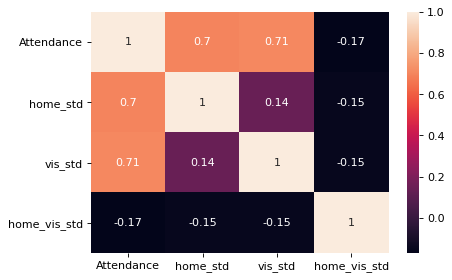

In [139]:
corr2c = df1b.corr()
_ = sns.heatmap(corr2c, annot=True)

y_data_b = df1b['Attendance']
X_data_ar_b = np.array([df1b['home_std'], df1b['vis_std'], df1b['home_vis_std']])
X_data_b_T = X_data_ar_b.T
X_data_b = pd.DataFrame(X_data_b_T, columns = ['home_std', 'vis_std', 'home_vis_std'])
X_data_b = sm.add_constant(X_data_b)
olsmod_b = sm.OLS(y_data_b, X_data_b)
result_reg_b = olsmod_b.fit()
print(result_reg_b.summary())
Estimated_model(xname,result_reg_b,xsize,yname)

#(b)
Since p-value for F-test, R-squared are both nice&there are variables can reject h0, it is valid

<div style="background-color:#D9D9D9;"><font size="5"> 18.19</font></div>
Refer to Exercise 17.12 where the 
amount of time to unload a truck was analyzed. The 
manager realized that another variable, the time of 
day, may affect unloading time. He recorded the 
following codes: 1 = morning, 2 = early afternoon, 
and 3 = late afternoon.

a. Run a regression using the codes for time of day.

b. Create indicator variables to represent time of 
day. Perform a regression analysis with these 
new variables.

c. Which model fits better? Explain.

d. Is time of day related to time to unload


In [140]:
df1 = pd.read_excel('Xr17-12.xlsx')
display(df1.tail())

,Time,Boxes,Weight,Codes
45,36,101,14.86,1
46,77,150,50.02,1
47,63,146,40.83,1
48,50,137,7.50,1
49,59,140,17.30,1


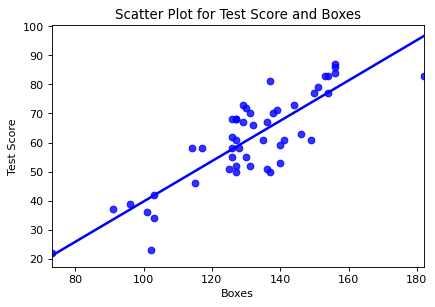

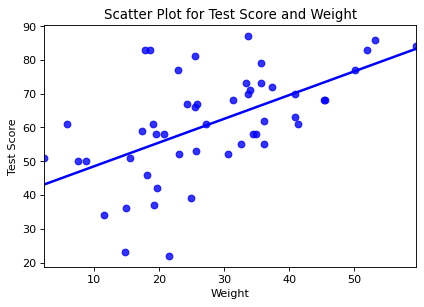

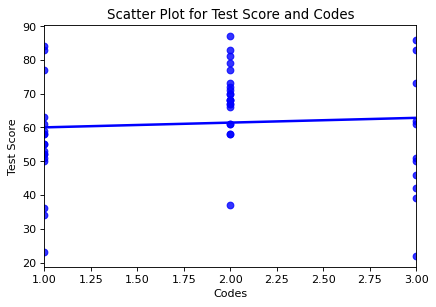

In [141]:
y_var = df1['Time'].values
xnames = df1.columns[1:]
for aname in xnames:
    x_var = df1[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df1b, color = 'b', ci = None)
    #_ = plt.plot(x, y, 'o', color = 'b')
    plt.xlabel(aname)
    plt.ylabel('Test Score')
    plt.title('Scatter Plot for Test Score and ' +aname)
    plt.show()

In [142]:
y_data_b = df1['Time']
X_data_ar_b = np.array([df1['Boxes'], df1['Weight'], df1['Codes']])
X_data_b_T = X_data_ar_b.T
X_data_b = pd.DataFrame(X_data_b_T, columns = ['Boxes', 'Weight', 'Codes'])
X_data_b = sm.add_constant(X_data_b)
olsmod_b = sm.OLS(y_data_b, X_data_b)
result_reg_b = olsmod_b.fit()
print(result_reg_b.summary())


                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     88.64
Date:                Wed, 11 May 2022   Prob (F-statistic):           3.87e-19
Time:                        12:21:23   Log-Likelihood:                -160.48
No. Observations:                  50   AIC:                             329.0
Df Residuals:                      46   BIC:                             336.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -41.4221      7.000     -5.917      0.0

### (a)
regression :<br>
Time = -41.4221 + 0.6441 Boxes + 0.6441 Weight + 4.5427 Codes

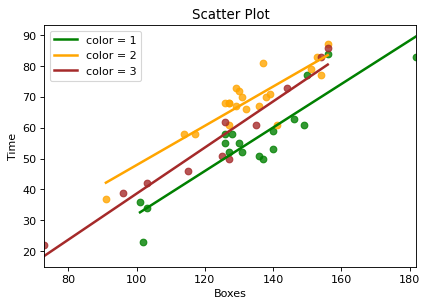

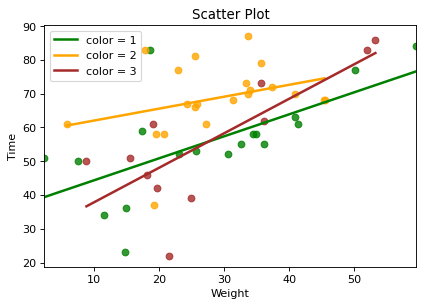

In [143]:
df1c1 = df1[df1.Codes == 1]
df1c2 = df1[df1.Codes == 2]
df1c3 = df1[df1.Codes == 3]
_ = sns.regplot(x='Boxes', y= 'Time', data = df1c1, color = 'green', ci = None)
_ = sns.regplot(x='Boxes', y= 'Time', data = df1c2, color = 'orange', ci = None)
_ = sns.regplot(x='Boxes', y= 'Time', data = df1c3, color = 'brown', ci = None)
plt.legend(labels=['color = 1', 'color = 2', 'color = 3'])
plt.title('Scatter Plot')
plt.xlabel('Boxes')
plt.ylabel('Time')
plt.show()
_ = sns.regplot(x='Weight', y= 'Time', data = df1c1, color = 'green', ci = None)
_ = sns.regplot(x='Weight', y= 'Time', data = df1c2, color = 'orange', ci = None)
_ = sns.regplot(x='Weight', y= 'Time', data = df1c3, color = 'brown', ci = None)
plt.legend(labels=['color = 1', 'color = 2', 'color = 3'])
plt.title('Scatter Plot')
plt.xlabel('Weight')
plt.ylabel('Time')
plt.show()

In [144]:
Codes_dummy = pd.get_dummies(df1['Codes'], prefix = 'Codes')
df1b = pd.concat([df1, Codes_dummy], axis = 1)
df1b.head()
y_data_5b = df1b['Time']
X_data_ar_5b = np.array([df1b['Boxes'], df1b['Weight'], df1b['Codes_1'], df1b['Codes_2']])
X_data_5b_T = X_data_ar_5b.T
X_data_5b = pd.DataFrame(X_data_5b_T, columns = ['Boxes', "Weight", 'Codes_1', 'Codes_2'])
X_data_5b = sm.add_constant(X_data_5b)
olsmod_5b = sm.OLS(y_data_5b, X_data_5b)
result_reg_5b = olsmod_5b.fit()
print(result_reg_5b.summary())

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     197.7
Date:                Wed, 11 May 2022   Prob (F-statistic):           6.31e-28
Time:                        12:21:24   Log-Likelihood:                -135.30
No. Observations:                  50   AIC:                             280.6
Df Residuals:                      45   BIC:                             290.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.7180      3.727     -7.973      0.0

### (b)
<br>Add new indicator variable:<br>
Time = -29.7180 + 0.6177 Boxes + 0.3464 Weight -6.7556 Codes_1 + 6.4800 Codes_2

### (c)
b is better, since its Adj. R-squared is higher than the previous one.

### (d)
Yes, because both of Codes_1 and Codes_2 reject t-test, we can conclude time of day related to time to unload.

<div style="background-color:#D9D9D9;"><font size="5"> 18.23</font></div>
Xr18-23 Absenteeism is a serious employment problem in most countries. It is 
estimated that absenteeism reduces potential output by more than 10%. Two 
economists launched a research project to learn more about the problem. They 
randomly selected 100 organizations to participate in a 1-year study. For each 
organization, they recorded the average number of days absent per employee and 
several variables thought to affect absenteeism. The following data were recorded: <br>
Column 1: Average number of days absent per employee<br>
Column 2: Average employee wage<br>
Column 3: Percentage of part-time employees<br>
Column 4: Percentage of unionized employees<br>
Column 5: Availability of shiftwork (1 = yes; 0 = no)<br>
Column 6: Union–management relationship (1 = good; 0 = not good)<br>
a. Conduct a regression analysis.<br>

b. Can we infer at the 5% significance level that the availability of shiftwork <br>
is related to absenteeism?<br>

c. Is there enough evidence at the 5% significance level to infer that in organizations where the union–management relationship is good, absenteeism is 
lower?<br>

In [145]:
df1 = pd.read_excel('Xr18-23.xlsx')
display(df1.tail())

,Absent,Wage,Pct PT,Pct U,Av Shift,UM Rel
95,2.7,28878,7.4,12.2,1,1
96,8.0,24558,24.5,37.0,1,1
97,4.2,20447,0.9,27.4,1,1
98,9.0,27714,8.7,58.1,0,0
99,7.7,18116,3.5,47.5,1,1


In [146]:
y_data_b = df1['Absent']
X_data_ar_b = np.array([df1['Wage'], df1['Pct PT'], df1['Pct U'], df1['Av Shift'], df1['UM Rel']])
X_data_b_T = X_data_ar_b.T
X_data_b = pd.DataFrame(X_data_b_T, columns = ['Wage', 'Pct PT', 'Pct U', 'Av Shift', 'UM Rel'])
X_data_b = sm.add_constant(X_data_b)
olsmod_b = sm.OLS(y_data_b, X_data_b)
result_reg_b = olsmod_b.fit()
print(result_reg_b.summary())

                            OLS Regression Results                            
Dep. Variable:                 Absent   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     21.40
Date:                Wed, 11 May 2022   Prob (F-statistic):           3.08e-14
Time:                        12:21:25   Log-Likelihood:                -224.49
No. Observations:                 100   AIC:                             461.0
Df Residuals:                      94   BIC:                             476.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2648      1.172      8.756      0.0

### (a.)
regression :<br>
Absent = 10.2648 - 0.0002 Wage -0.1069 Pct PT + 0.0599 Pct U + 1.5619 Av Shift - 2.6366 UM Rel

### (b.)
by t-test for Av Shift, p-value < 0.05 rejected H0, we can conclude that the availability of shiftwork
is related to absenteeism.

### (c.)
Because the coefficient for Union–management relationship is nagetive, and the F statistics p-value < 0.05 rejected H0 by t-test , we can conclude that organizations where the union–management relationship is good, have lower absenteeism.

<div style="background-color:#D9D9D9;"><font size="5"> 18.36</font></div>
Re-do Example 18.4 by assigning your own values 
to each factor and to the weights. What conclusion 
did you reach?<br>

A fast-food restaurant chain whose menu features hamburgers and chicken 
sandwiches is about to add a fish sandwich to its menu. There was considerable 
debate among the executives about the likely demand and what the appropriate 
price should be. A recently hired economics graduate observed that the demand 
curve would reveal a great deal about the relationship between price and demand. 
She convinced the executives to conduct an experiment. A random sample of 
20 restaurants was drawn. The restaurants were almost identical in terms of sales 
and in the demographics of the surrounding area. At each restaurant, the fish sandwich was sold at a different price. The number of sandwiches sold over a 7-day 
period and the price were recorded. A first-order model and a second-order model 
were proposed.


a. Write the equation for each model.


b. Use regression analysis to estimate the coefficients and other statistics for each 
model.


c. Which model seems to fit better? Explain.


d. Use the better model to calculate the point prediction for weekly sales when 
the price is $2.95

In [147]:
df1 = pd.read_excel('Xr18-04.xlsx')
display(df1.tail())

,Sales,Price
15,268,2.69
16,270,2.75
17,269,2.79
18,265,2.89
19,268,2.99


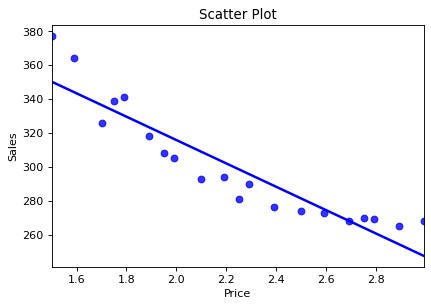

In [148]:
y_var = df1['Sales'].values
xnames =['Price']
for aname in xnames:
    x_var = df1[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df1, color = 'b', ci = None)
    plt.title('Scatter Plot')
    plt.xlabel(aname)
    plt.ylabel('Sales')
    plt.show()

In [149]:
y_data = df1['Sales']
X_data_ar = np.array([df1['Price']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = ['Price'])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
result_reg = olsmod.fit()
print(result_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     106.4
Date:                Wed, 11 May 2022   Prob (F-statistic):           5.51e-09
Time:                        12:21:27   Log-Likelihood:                -79.065
No. Observations:                  20   AIC:                             162.1
Df Residuals:                      18   BIC:                             164.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        453.5555     15.182     29.874      0.0

first order regression model : Sales = 453.5555 - 68.9122 Price

second order
[-359.10049572   64.54729507  766.91044162]
y = -359.10050 * x + 64.54730 * x^2 + 766.91044


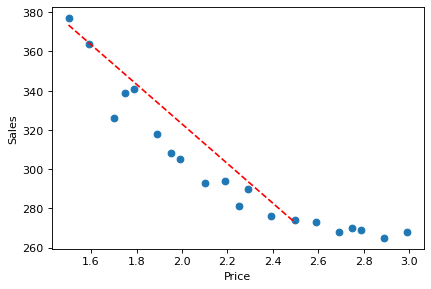

In [150]:
y_var = df1['Sales'].values
xnames = ['Price']
for aname in xnames:
    x_var = df1[aname].values
    print("second order")
    popt, _ = curve_fit(objective, x_var, y_var)
    print(popt)
    a, b, c = popt
    print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
    plt.scatter(x_var, y_var)
    x_line = np.arange(min(x_var), max(x_var), 1)
    y_line = objective(x_line, a, b, c)
    plt.plot(x_line, y_line, '--', color='red')
    plt.xlabel(aname)
    plt.ylabel('Sales')
    plt.show()

In [151]:
dep_var = df1['Sales']
indep_var = df1[['Price']]
#Change the names so that we will not get confused
indep_var.columns = ['price_std']
indep_mean = indep_var.mean()
indep_var['price_std2'] = indep_var['price_std'] ** 2
df1b = indep_var.copy()
df1b.insert(0, 'Sales', dep_var)
df1b.head()


,Sales,price_std,price_std2
0,377,1.50,2.2500
1,364,1.59,2.5281
2,326,1.70,2.8900
3,339,1.75,3.0625
4,341,1.79,3.2041


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     301.2
Date:                Wed, 11 May 2022   Prob (F-statistic):           5.34e-14
Time:                        12:21:27   Log-Likelihood:                -62.445
No. Observations:                  20   AIC:                             130.9
Df Residuals:                      17   BIC:                             133.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        766.9104     37.405     20.503      0.0

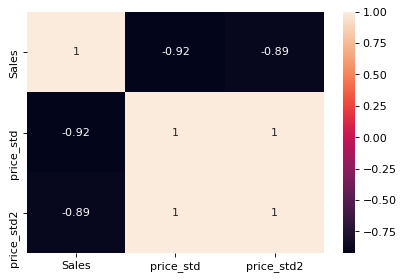

In [152]:
corr2c = df1b.corr()
_ = sns.heatmap(corr2c, annot=True)

y_data_b = df1b['Sales']
X_data_ar_b = np.array([df1b['price_std'], df1b['price_std2']])
X_data_b_T = X_data_ar_b.T
X_data_b = pd.DataFrame(X_data_b_T, columns = ['price_std', 'price_std2'])
X_data_b = sm.add_constant(X_data_b)
olsmod_b = sm.OLS(y_data_b, X_data_b)
result_reg_b = olsmod_b.fit()
print(result_reg_b.summary())

F-test reject H0, but no variable can reject t-test, there is multicollinearity<br>
do the Data Transformation

In [153]:
# 做Data Transformation
dep_var = df1['Sales']
indep_var = df1[['Price']]
#Change the names so that we will not get confused
indep_var.columns = ['price_std']
indep_mean = indep_var.mean()
indep_var = indep_var - indep_mean
indep_var['price_std2'] = indep_var['price_std'] ** 2
df1b = indep_var.copy()
df1b.insert(0, 'Sales', dep_var)
df1b.head()

,Sales,price_std,price_std2
0,377,-0.729,0.531441
1,364,-0.639,0.408321
2,326,-0.529,0.279841
3,339,-0.479,0.229441
4,341,-0.439,0.192721


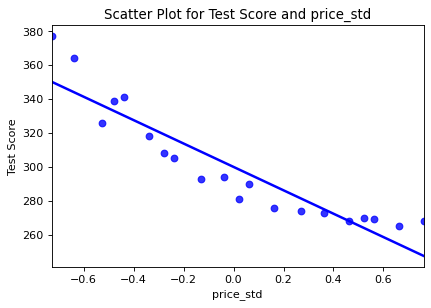

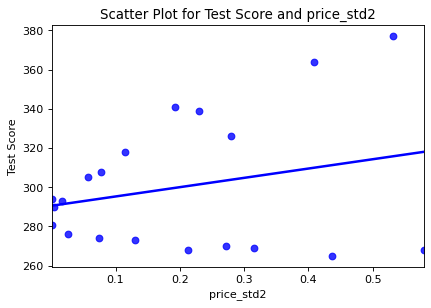

In [154]:
y_var = df1b['Sales'].values
xnames = df1b.columns[1:]
for aname in xnames:
    x_var = df1b[aname].values
    _ = sns.regplot(x = x_var, y = y_var, data = df1b, color = 'b', ci = None)
    #_ = plt.plot(x, y, 'o', color = 'b')
    plt.xlabel(aname)
    plt.ylabel('Test Score')
    plt.title('Scatter Plot for Test Score and ' +aname)
    plt.show()

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     301.2
Date:                Wed, 11 May 2022   Prob (F-statistic):           5.34e-14
Time:                        12:21:28   Log-Likelihood:                -62.445
No. Observations:                  20   AIC:                             130.9
Df Residuals:                      17   BIC:                             133.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        287.1749      2.006    143.180      0.0

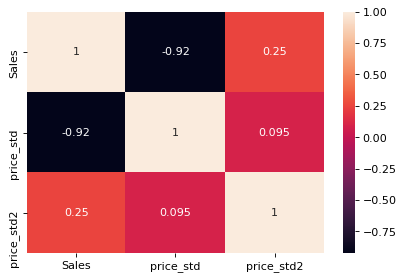

In [155]:
corr2c = df1b.corr()
_ = sns.heatmap(corr2c, annot=True)

y_data_b = df1b['Sales']
X_data_ar_b = np.array([df1b['price_std'], df1b['price_std2']])
X_data_b_T = X_data_ar_b.T
X_data_b = pd.DataFrame(X_data_b_T, columns = ['price_std', 'price_std2'])
X_data_b = sm.add_constant(X_data_b)
olsmod_b = sm.OLS(y_data_b, X_data_b)
result_reg_b = olsmod_b.fit()
print(result_reg_b.summary())


F-test reject H0, and there are variables that reject t-test, so there is no multicollinearity
regression model :<br>
Sales = 287.1749 - 71.3487 (price_std - price_mean) + 64.5473 (price - price_mean )^2

### (b)
first_order model:<br>
Sales = 453.5555 - 68.9122 Price<br>
every additional unit of price reduce 68.9122 Sales units <br>

Second_order model:<br>
Sales = 287.1749 - 71.3487 (price_std - price_mean) + 64.5473 (price - price_mean )^2<br>
every additional unit of price reduce 71.3487 Sales units,<br>
every additional unit of price^2 add 65.5473 Sales units

### (c)
second_order model is better because its Adj. R-squared is higher.

### (d)

In [156]:
print("the sales number is 453.55-68.9122*2.95 = ", 453.55-68.9122*2.95)
print("revenue = ",(453.55-68.9122*2.95)*2.95)

the sales number is 453.55-68.9122*2.95 =  250.25901
revenue =  738.2640795


<div style="background-color:#D9D9D9;"><font size="5"> 18.38</font></div>
Refer to Exercise 17.16.  <br>
a. Use stepwise regression to compute the regression equation. <br>
b. Compare the output with that produced in 
Exercise 17.16.

In [157]:
df1 = pd.read_excel('Xr17-16.xlsx')
df1

,DEFINITE,DAYS1,DAYS2,DAYS3,DAYS4,DAYS5,DAYS6
0,10,0,0,0,0,0,7
1,10,0,0,3,3,0,0
2,10,3,0,1,0,2,3
3,5,3,0,5,7,1,0
4,10,7,0,3,3,4,0
...,...,...,...,...,...,...,...
887,10,5,5,5,6,0,0
888,5,7,7,0,1,0,0
889,10,5,5,0,0,0,0
890,10,7,5,7,0,0,5


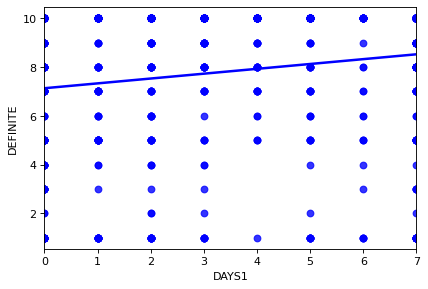

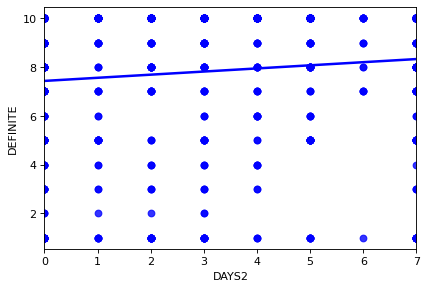

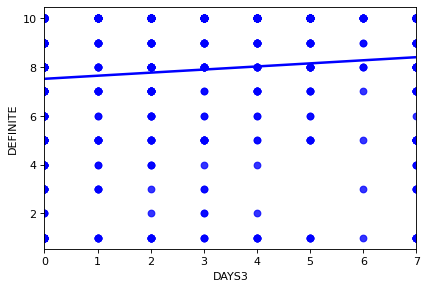

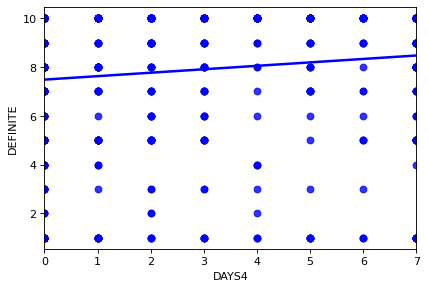

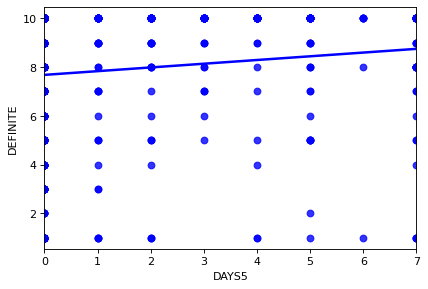

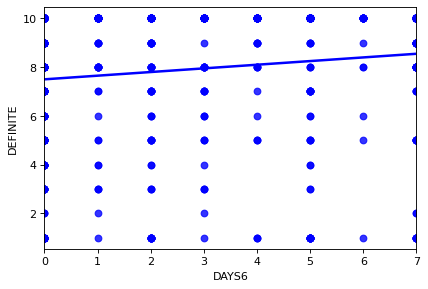

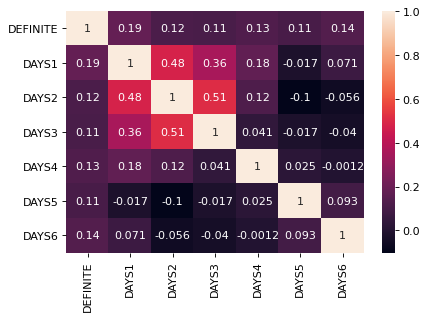

In [158]:
y_var = df1['DEFINITE'].values
xnames = ['DAYS1', 'DAYS2', 'DAYS3', 'DAYS4', 'DAYS5', 'DAYS6']
for aname in xnames:
    x_var = df1[aname].values
    _ = sns.regplot(x=x_var, y=y_var, data = df1, color = 'blue', ci = None)
    plt.xlabel(aname)
    plt.ylabel('DEFINITE')
    plt.show()
corr6 = df1.corr()
_ = sns.heatmap(corr6, annot=True)

In [159]:
forward_selection(input_df = df1, depv = 'DEFINITE', indepv = ['DAYS1', 'DAYS2', 'DAYS3', 'DAYS4', 'DAYS5', 'DAYS6'])

Current Candidates:  ['DAYS1', 'DAYS2', 'DAYS3', 'DAYS4', 'DAYS5', 'DAYS6']
Current best model:  ['DAYS1']
Current best AdjR2:  0.0335726177176392
Current Candidates:  ['DAYS2', 'DAYS4', 'DAYS6', 'DAYS5', 'DAYS3']
Current best model:  ['DAYS1', 'DAYS6']
Current best AdjR2:  0.04760823822379723
Current Candidates:  ['DAYS4', 'DAYS2', 'DAYS5', 'DAYS3']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4']
Current best AdjR2:  0.056642285730147734
Current Candidates:  ['DAYS2', 'DAYS5', 'DAYS3']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5']
Current best AdjR2:  0.06483946084093561
Current Candidates:  ['DAYS2', 'DAYS3']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5', 'DAYS3']
Current best AdjR2:  0.0676651778452596
Current Candidates:  ['DAYS2']
Current best model:  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5', 'DAYS3', 'DAYS2']
Current best AdjR2:  0.06730270416755912
best_adjr2 =  0.0676651778452596
best_subset =  ['DAYS1', 'DAYS6', 'DAYS4', 'DAYS5', 'DAYS3']
                   

regression model :<br>
DEFINITE = 6.4057 + 0.1470 Days1 + 0.0744 Days3 +  0.1092 Days4 +  0.1379 Days5 + 0.1320 Days6

In [160]:
y_data = df1['DEFINITE']
X_data_ar = np.array([df1['DAYS1'], df1['DAYS2'],df1['DAYS3'], df1['DAYS4'], df1['DAYS5'], df1['DAYS6']])
X_data_T = X_data_ar.T
X_data = pd.DataFrame(X_data_T,columns = df1.columns[1:])
X_data2 = sm.add_constant(X_data)
olsmod = sm.OLS(y_data, X_data2)
result_reg = olsmod.fit()
print(result_reg.summary())
#forward_selection(input_df = df1, depv = 'DEFINITE', indepv = ['DAYS1', "DAYS2", "DAYS3","DAYS4","DAYS5","DAYS6"])

                            OLS Regression Results                            
Dep. Variable:               DEFINITE   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     11.72
Date:                Wed, 11 May 2022   Prob (F-statistic):           1.16e-12
Time:                        12:21:31   Log-Likelihood:                -2199.2
No. Observations:                 892   AIC:                             4412.
Df Residuals:                     885   BIC:                             4446.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3646      0.205     31.099      0.0

DEFINITE = 6.3646 + 0.1350 Days1 + 0.0363 Days2 + 0.0601 Days3 + 0.1074 Days4 + 0.1419 Days5 + 0.1341 Days6<br>
in the new regression model DAYS2 is considered not to be put in, whereas in 17.16 it's an independent variable

<div style="background-color:#D9D9D9;"><font size="5"> 18.49</font></div>
The maintenance of swimming pools is 
quite costly because of all the chlorine that is needed
to keep the water clear and relatively free of germs. 
A chain of hotels (all with outdoor pools) seeking 
to reduce costs decided to analyze the factors that 
determine how much chlorine is needed. They 
commissioned a chemist to conduct an analysis. 
It is believed that the speed at which chlorine in a 
pool is depleted is dependent on the temperature 
of the water (higher temperature uses chlorine 
faster); pH level, which is a measure of the acidity 
of the water (pH ranges from 0 to 14, where 0 is 
very acidic and 14 is very alkaline; levels around 7.5 
use the least chlorine); and weather (sunshine uses 
up chlorine). The chemist conducted the following 
experiment. The percentage of chlorine depletion 
during 8-hour days was recorded under varying 
conditions of pH level, water temperature, and 
weather conditions. These data were recorded in 
the following way:<br>
Column 1: Percentage of chlorine depletion 
over 8 hours<br>
Column 2: Temperature (degrees Fahrenheit)<br>
Column 3: pH level<br>
Column 4: 1 = Mainly cloudy, 2 = Sunny, 
3 = Partly sunny<br>
a. Write the equation of the model that you would 
suggest.<br>
b. Use regression analysis to estimate the model's 
coefficients.<br>
c. Test to determine whether the model is valid.<br>
d. Can we infer that higher temperatures deplete 
chlorine more quickly?<br>
e. Is there evidence to infer that the belief about 
the relationship between chlorine depletion and 
pH level is correct?<br>
f. Can we infer that weather is a factor in chlorine 
depletion?<br>

In [161]:
df1 = pd.read_excel('Xr18-49.xlsx')
df1

,Pct Dep,Temperature,PH Level,Weather
0,32.6,60,6.6,2
1,40.4,65,6.6,2
2,39.4,70,6.6,2
3,37.3,75,6.6,2
4,45.1,80,6.6,2
...,...,...,...,...
205,33.6,70,8.4,1
206,34.9,75,8.4,1
207,36.4,80,8.4,1
208,34.8,85,8.4,1


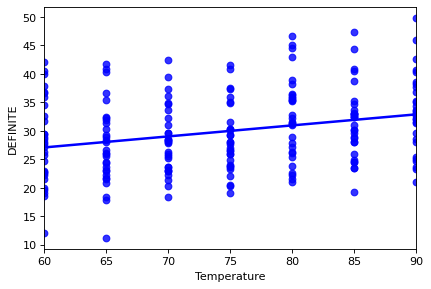

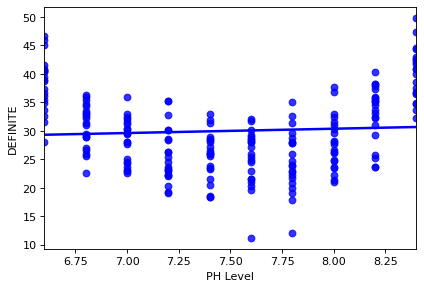

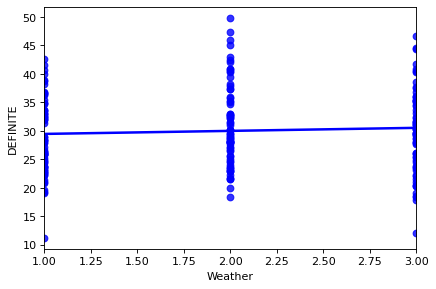

In [162]:
y_var = df1['Pct Dep'].values
xnames = ['Temperature', 'PH Level', 'Weather']
for aname in xnames:
    x_var = df1[aname].values
    _ = sns.regplot(x=x_var, y=y_var, data = df1, color = 'blue', ci = None)
    plt.xlabel(aname)
    plt.ylabel('DEFINITE')
    plt.show()

In [163]:
Weather_dummy = pd.get_dummies(df1['Weather'], prefix = 'Weather')
df1b = pd.concat([df1, Weather_dummy], axis = 1)
df1b.head()
df1b.rename(columns={'Pct Dep': 'Pct_Dep', 'PH Level': "PH_Level"}, inplace=True)
df1b

,Pct_Dep,Temperature,PH_Level,Weather,Weather_1,Weather_2,Weather_3
0,32.6,60,6.6,2,0,1,0
1,40.4,65,6.6,2,0,1,0
2,39.4,70,6.6,2,0,1,0
3,37.3,75,6.6,2,0,1,0
4,45.1,80,6.6,2,0,1,0
...,...,...,...,...,...,...,...
205,33.6,70,8.4,1,1,0,0
206,34.9,75,8.4,1,1,0,0
207,36.4,80,8.4,1,1,0,0
208,34.8,85,8.4,1,1,0,0


In [164]:
result_reg = forward_selection(input_df = df1b, depv = 'Pct_Dep', indepv = ['Temperature', 'PH_Level', 'Weather_1', 'Weather_2'])

Current Candidates:  ['Temperature', 'PH_Level', 'Weather_1', 'Weather_2']
Current best model:  ['Temperature']
Current best AdjR2:  0.07369856595316526
Current Candidates:  ['Weather_1', 'PH_Level', 'Weather_2']
Current best model:  ['Temperature', 'Weather_2']
Current best AdjR2:  0.08258210579517977
Current Candidates:  ['Weather_1', 'PH_Level']
Current best model:  ['Temperature', 'Weather_2', 'Weather_1']
Current best AdjR2:  0.08214670909706112
Current Candidates:  ['PH_Level']
Current best model:  ['Temperature', 'Weather_2', 'Weather_1', 'PH_Level']
Current best AdjR2:  0.08168309124679562
best_adjr2 =  0.08258210579517977
best_subset =  ['Temperature', 'Weather_2']
                            OLS Regression Results                            
Dep. Variable:                Pct_Dep   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     10.41
D

### (a.)
Forward Stepwise suggest me to use'temperature', 'Weather Sunny' as regresssion model variables<br>
y = 14.8950 + 0.1938 Temperature + 1.6914 Weather_2

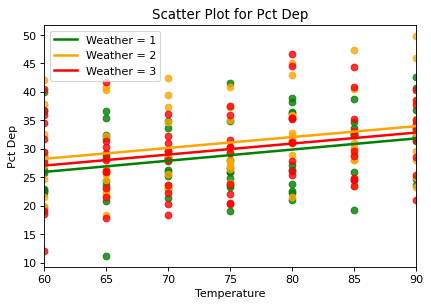

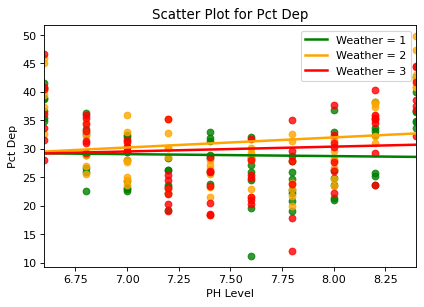

the line looks well.


In [165]:
#(b.)
df_w1 = df1[df1['Weather'] == 1]
df_w2 = df1[df1['Weather'] == 2]
df_w3 = df1[df1['Weather'] == 3]

xlist = ['Temperature','PH Level']

for name in xlist:
    _ = sns.regplot(x=name, y= 'Pct Dep', data = df_w1, color = 'green', ci = None)
    _ = sns.regplot(x=name, y= 'Pct Dep', data = df_w2, color = 'orange', ci = None)
    _ = sns.regplot(x=name, y= 'Pct Dep', data = df_w3, color = 'red', ci = None)
    plt.legend(labels=['Weather = 1', 'Weather = 2', 'Weather = 3'])
    plt.title('Scatter Plot for Pct Dep')
    plt.xlabel(name)
    plt.ylabel('Pct Dep')
    plt.show()
print("the line looks well.")

In [166]:
df1["time"] = df1.index
w_dummy = pd.get_dummies(df1['Weather'], prefix = 'w')

df1_b = pd.concat([df1,w_dummy], axis = 1)
display(df1_b.head())
#xlist = ['Wage','Pct PT','Pct U']
# xlist = ['Temperature','PH Level']
y_data_5b = df1['Pct Dep']
X_data_ar_5b = np.array([df1_b['Temperature'],df1_b['time'],df1_b['PH Level'],df1_b['w_1'],\
                         df1_b['w_2'],df1_b['w_3']])
X_data_5b_T = X_data_ar_5b.T
X_data_5b = pd.DataFrame(X_data_5b_T, columns = ['Temperature','PH Level','w_1','w_2','w_3','time'])
X_data_5b = sm.add_constant(X_data_5b)
olsmod_5b = sm.OLS(y_data_5b, X_data_5b)
result_reg_5b = olsmod_5b.fit()
print(result_reg_5b.summary())

xname = ["",'Temperature','PH Level','w_1','w_2','w_3','time']
yname = 'Pct Dep'
xsize = 6
st, data, ss2 = sso.summary_table(result_reg_5b, alpha=0.05)
print("Columns in data are: %s" % ss2)
#Predicted value
y_pre = data[:, 2]
#Studentized Residual
SD = data[:, 10]
mu = np.mean(SD)
sigma = np.std(SD)
print(SD)
#print('mu = ', mu)
#print('sigma = ', sigma)

,Pct Dep,Temperature,PH Level,Weather,time,w_1,w_2,w_3
0,32.6,60,6.6,2,0,0,1,0
1,40.4,65,6.6,2,1,0,1,0
2,39.4,70,6.6,2,2,0,1,0
3,37.3,75,6.6,2,3,0,1,0
4,45.1,80,6.6,2,4,0,1,0


                            OLS Regression Results                            
Dep. Variable:                Pct Dep   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     5.648
Date:                Wed, 11 May 2022   Prob (F-statistic):           0.000248
Time:                        12:21:32   Log-Likelihood:                -693.59
No. Observations:                 210   AIC:                             1397.
Df Residuals:                     205   BIC:                             1414.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3056      0.079      3.846      

### (c)
H0: beta_1 = beta_2 = beta_3 = 0 <br>
H1: At least one of the betas != 0

In [167]:
A = np.identity(len(result_reg.params))
A = A[1:,:]
print("F test = ", result_reg.f_test(A))

F test =  <F test: F=array([[10.40665111]]), p=4.9373742051879677e-05, df_denom=207, df_num=2>


Since p-value = 0 < alpha = 0.05, we can reject H0.<br>
There is enough evidence to conclude that the model is valid.

### (d)
Since the slope coefficient of Temperature is positive, <br>
we infer that higher temperatures deplete chlorine more quickly

### (e)
No

β denotes the slope of regression of pH level,alpha = 0.05<br>
H0:β = 0<br>
H1:β ≠ 0<br>
Since the p-value=0.174 > 0.05. We can't reject H0. We can't infer at the 5% significance level that relationship between chlorine depletion and pH level is correct.

### (f)
yes, weather_1('Mainly cloudy') 's t-test is smaller than 0.05, thus we can believe that weather is an important variable. We can also know from the forward selection.